# Competitor Analysis

Compare: 
* Random Search
* SMAC
* BOHB
* HB
* Smashy (in best version, needs to be included still)

In [16]:
algos = c("randomsearch_full_budget", "smac_full_budget", "mlr3hyperband", "hpbster_bohb")

In [17]:
library(data.table)
library(ggplot2)
library(ggpubr)
library(xtable)

source("../publication_themes.R")
source("../helper.R")

theme_set(theme_Publication())

scale_colour_discrete = scale_colour_Publication()
scale_fill_discrete = scale_fill_Publication()

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [18]:
instances = readRDS("../../../paper_2021_multi_fidelity_surrogates/inst/instances.rds")

## LCBench

### Preparation

In [19]:
prob = "lcbench"

In [5]:
fps = list.files("../../results//reduced_files/lcbench/sequential/", full.names = TRUE)

In [126]:
df = readAndConcatenateFiles(fps)

In [127]:
# Some additional computations for visualization
minmax = df[algorithm == "randomsearch_full_budget", ][, .(y_min = min(performance), y_max = max(performance)), by = c("task")]
df = merge(df, minmax, all.x = TRUE, by = c("task"))
df$regret = (df$performance - df$y_min) / (df$y_max - df$y_min)

df[, regret_cummin := cummin(regret), by = c("job.id")] 
df[, budget_cum := cumsum(budget), by = c("job.id")] 

In [128]:
df$algorithm = as.factor(df$algorithm)
levels(df$algorithm) = c("BOHB", "HB", "RS", "SMAC")

In [129]:
# Aggregate on per task level (across all replications)
dfa = df[, .(mean_nr = mean(regret_cummin), sd_nr = sd(regret_cummin), n = .N), by = c("algorithm", "problem", "task", "budget_cum")]

In [130]:
# Aggregation across tasks
inst = instances[cfg == "lcbench", ]
test = inst[test == TRUE, ]$level
train = inst[test == FALSE, ]$level

# Aggregated for all training instances
dfa_test = dfa[task %in% test, .(mean_nr_across_tasks = mean(mean_nr)), by = c("algorithm", "problem", "budget_cum")]

df_agg = list(train = dfa_train, teset = dfa_test)

### Analysis: Learning Curves 

In [131]:
storepath = file.path("../../results/figures", prob)
dir.create(storepath, recursive = TRUE)

Warning message in dir.create(storepath, recursive = TRUE):
“'../../results/figures/lcbench' already exists”


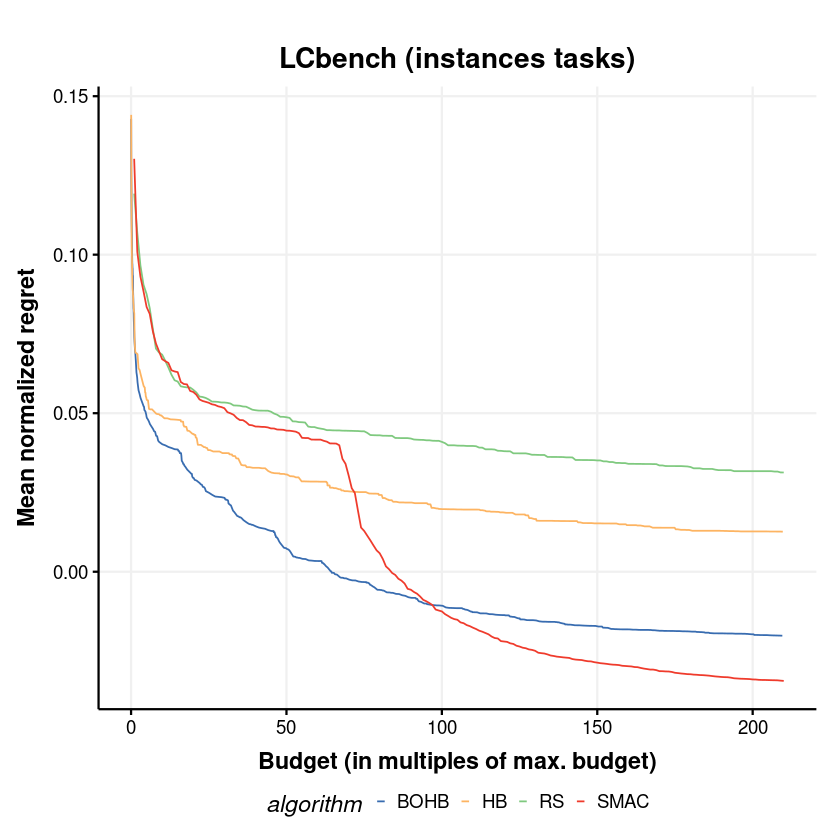

In [132]:
# Learning curves, aggregated across tasks, test set 
dfa_train = dfa[task %in% train, .(mean_nr_across_tasks = mean(mean_nr)), by = c("algorithm", "problem", "budget_cum")]

p = ggplot(data = dfa_train) + geom_line(aes(x = budget_cum / 52, y = mean_nr_across_tasks, colour = algorithm)) 
p = p + scale_colour_Publication()
p = p + xlab("Budget (in multiples of max. budget)") + ylab("Mean normalized regret")
p = p + ggtitle(paste0("LCbench (instances tasks)"))
p

In [133]:
ggsave(file.path(storepath, paste0("learning_curve_train.png")), p, width = 5, height = 4)

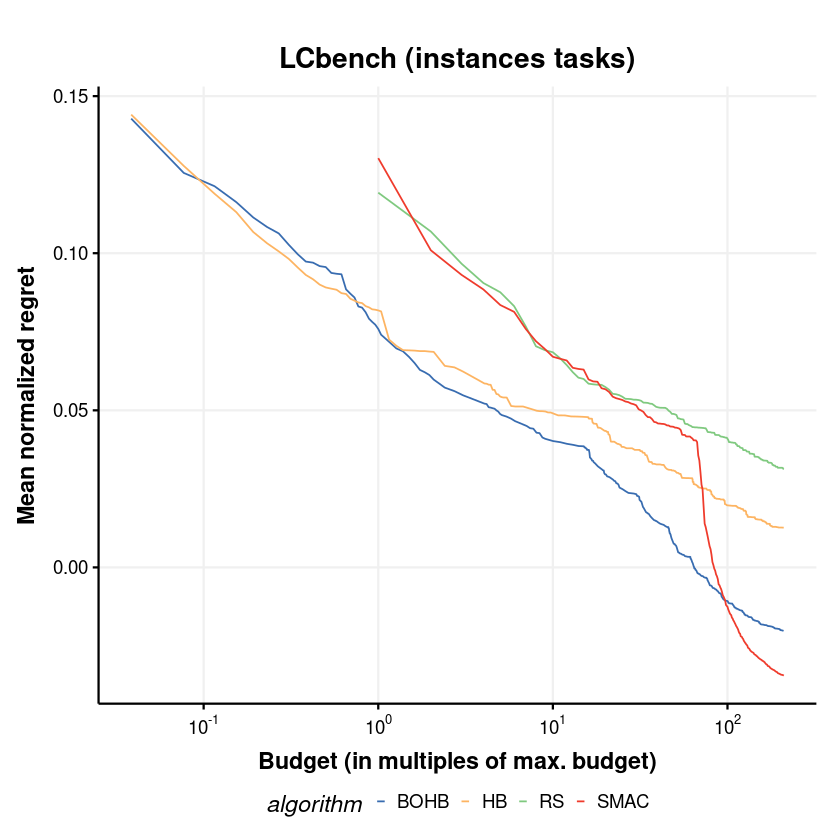

In [134]:
p = p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
p

In [135]:
ggsave(file.path(storepath, paste0("learning_curve_train_log.png")), p, width = 5, height = 4)

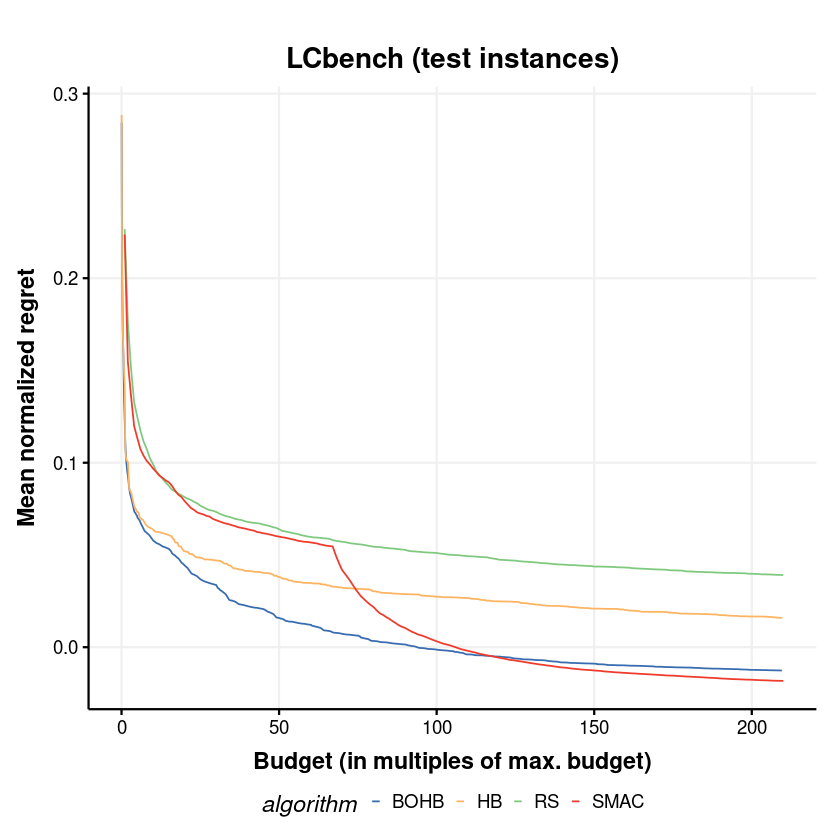

In [136]:
# Learning curves, aggregated across tasks, test set 
dfa_test = dfa[task %in% test, .(mean_nr_across_tasks = mean(mean_nr)), by = c("algorithm", "problem", "budget_cum")]

p = ggplot(data = dfa_test) + geom_line(aes(x = budget_cum / 52, y = mean_nr_across_tasks, colour = algorithm)) 
p = p + scale_colour_Publication()
p = p + xlab("Budget (in multiples of max. budget)") + ylab("Mean normalized regret")
p = p + ggtitle(paste0("LCbench (test instances)"))
p

In [137]:
ggsave(file.path(storepath, paste0("learning_curve_test.png")), p, width = 5, height = 4)

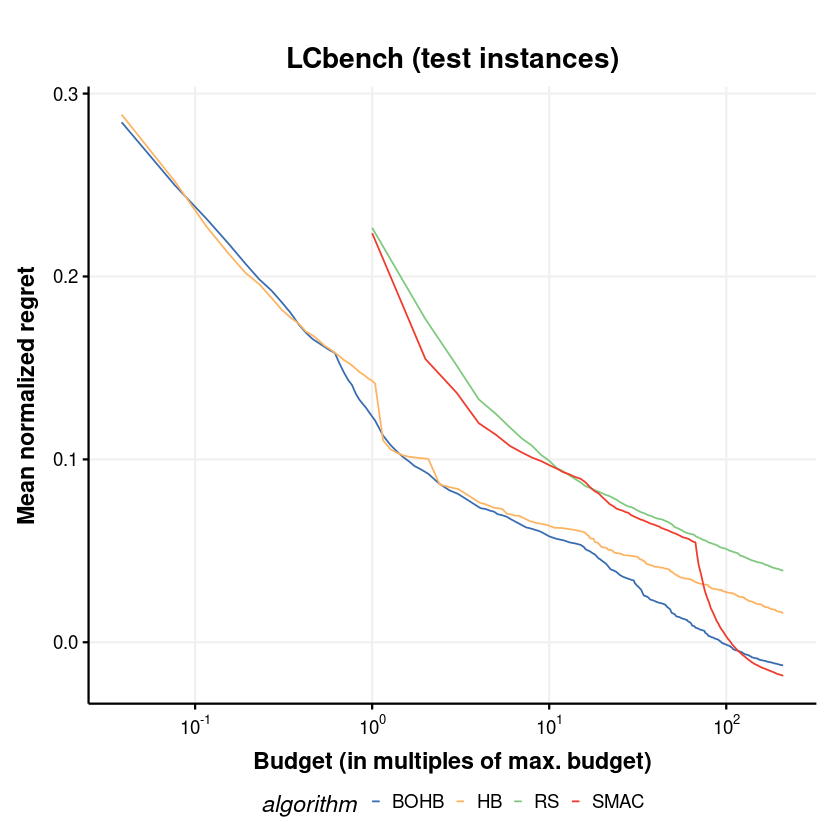

In [138]:
p = p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
p
ggsave(file.path(storepath, paste0("learning_curve_test_log.png")), p, width = 5, height = 4)

### Analysis: Rank Analysis (Test Instances) 

In [139]:
# Create a Rank Plot 
rank_table = lapply(c(1, 10, 100), function(bmax) {
    rt = df[task %in% test, .SD[budget_cum <= 52 * bmax]]
    rt = rt[, .SD[which.min(performance)], by = c("task", "job.id", "algorithm")]
    rt = rt[, repl := 1:.N, by = c("task", "algorithm")]
    rt[, rank := rank(performance), by = c("repl", "task")]
    rt = rt[, .(mean_rank_across_repls = mean(rank)), by = c("task", "algorithm")]
    rt = rt[, .(mean_rank = round(mean(mean_rank_across_repls), 2)), by = c("algorithm")]
    rt$bmax = 52 * bmax
    rt
})
rank_table = do.call(rbind, rank_table)

In [140]:
rank_table = reshape2::recast(data = rank_table, measure.var = "mean_rank", id.var = c("algorithm", "bmax"), formula = algorithm ~ bmax)
rank_table

algorithm,52,520,5200
<fct>,<dbl>,<dbl>,<dbl>
BOHB,1.66,1.82,1.70
HB,2.05,2.00,2.88
RS,3.15,3.11,3.61
SMAC,3.14,3.07,1.82


In [141]:
print(xtable(rank_table, type = "latex"), file = file.path(storepath, paste0("rank_table_test.tex")))

## RBV2_SUPER

### Preparation

In [5]:
prob = "rbv2_super"

fps = list.files(file.path("../../results//reduced_files", prob, "/sequential/"), full.names = TRUE)

df = readAndConcatenateFiles(fps)

In [6]:
df[, budget_cum := cumsum(budget), by = c("job.id")] 

In [14]:
# Reduce the resolution of the results (my R session crashes otherwise)
budgets = exp(seq(log(3^(-3)), log(1), length.out = 150))
budgets = c(budgets, seq(3^(-3), 1, length.out = 150))

In [15]:
out = lapply(budgets, function(bmax) {
    cbind(bmax = bmax, df[budget_cum <= bmax, .SD[which.min(performance)], by = "job.id"])
})

In [13]:
df = do.call(rbind, out)

bmax,job.id,problem,task,objectives,algorithm,budget,performance,budget_cum
<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
0.03703704,25741,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.07808932,0.03703704
0.03703704,25742,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,1.68880323,0.03703704
0.03703704,25743,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.10452451,0.03703704
0.03703704,25744,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.06460280,0.03703704
0.03703704,25745,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.23525697,0.03703704
0.03703704,25746,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.05918661,0.03703704
0.03703704,25747,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.04874629,0.03703704
0.03703704,25748,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.18126049,0.03703704
0.03703704,25749,rbv2_super,1040,logloss,hpbster_bohb,0.03703704,0.24268880,0.03703704


In [7]:
# FIXME: computing regret fails bc. ijoin fails 
minmax = df[algorithm == "randomsearch_full_budget"]
minmax = minmax[, .(y_min = min(performance), y_max = max(performance)), by = c("task")]

In [ ]:
dfl = lapply(unique(df$task), function(tt) {
    batchtools::ijoin(df[task == tt, ], minmax, by = c("task"))
})

In [ ]:
df = batchtools::ijoin(df, minmax, by = c("task"))
df$regret = (df$performance - df$y_min) / (df$y_max - df$y_min)
df[, regret_cummin := cummin(regret), by = c("job.id")] 

## NB301

### Preparation

In [5]:
prob = "nb301"

fps = list.files(file.path("../../results//reduced_files", prob, "/sequential/"), full.names = TRUE)

df = readAndConcatenateFiles(fps)
df$performance = abs(df$performance)
df$performance = df$performance * (-1)

# Some additional computations for visualization
minmax = df[algorithm == "randomsearch_full_budget", ][, .(y_min = min(performance), y_max = max(performance)), by = c("task")]
df = merge(df, minmax, all.x = TRUE, by = c("task"))
df$regret = (df$performance - df$y_min) / (df$y_max - df$y_min)
df[, regret_cummin := cummin(regret), by = c("job.id")] 
df[, budget_cum := cumsum(budget), by = c("job.id")] 

df$performance = df$performance * (-1)

df$algorithm = as.factor(df$algorithm)
levels(df$algorithm) = c("BOHB", "HB", "RS", "SMAC")

# Aggregate on per task level (across all replications)
dfa = df[, .(mean_nr = mean(regret_cummin), sd_nr = sd(regret_cummin), n = .N), by = c("algorithm", "problem", "budget_cum")]

### Analysis: Learning Curve

In [6]:
storepath = file.path("../../results/figures", prob)
dir.create(storepath, recursive = TRUE)

Warning message in dir.create(storepath, recursive = TRUE):
“'../../results/figures/nb301' already exists”


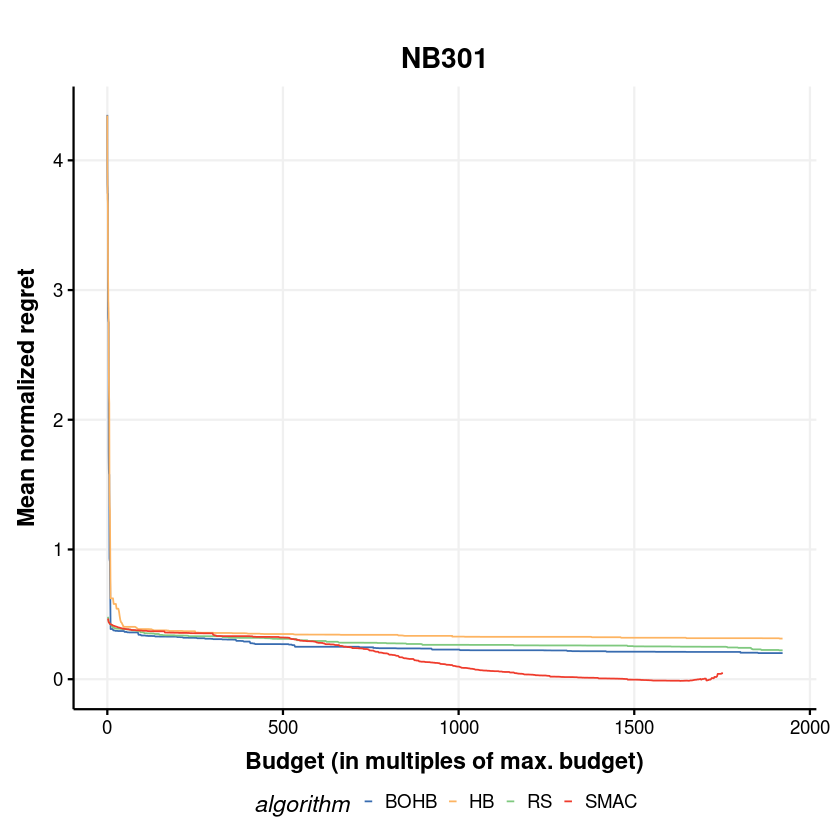

In [7]:
# Learning curves (only one task)
p = ggplot(data = dfa) + geom_line(aes(x = budget_cum / 52, y = mean_nr, colour = algorithm)) 
p = p + scale_colour_Publication()
p = p + xlab("Budget (in multiples of max. budget)") + ylab("Mean normalized regret")
p = p + ggtitle(paste0("NB301"))
p

In [152]:
ggsave(file.path(storepath, paste0("learning_curve.png")), p, width = 5, height = 4)

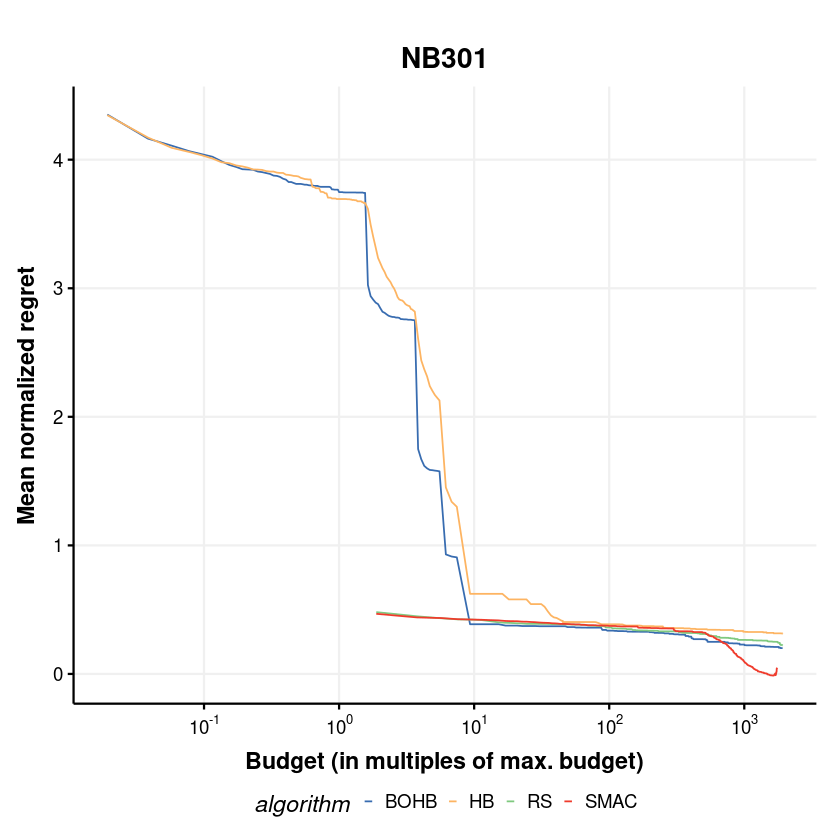

In [153]:
p = p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
p
ggsave(file.path(storepath, paste0("learning_curve_log.png")), p, width = 5, height = 4)